# Data Scientist Test Globant
Name: Jhoan Steven Delgado Villarreal

Problem: Diabetes

We start by doing a basic EDA (Exploratory Data Analysis) to understand and take a look at the variables to see if there are some interesting patterns, to check if there's missing data and also to do some cleaning and formatting. In order to achieve this, we use a library called pandas-profiling as a tool to assist us in this process. 

# EDA and cleaning

In [ ]:
#install pandas-profiling==1.4.1 
!pip install pandas-profiling[notebook]


In [ ]:
#install imbalanced-learn==0.4.3
!pip install -U imbalanced-learn

In [2]:
#Import the required libraries
import pandas as pd
import numpy as np
import math
from collections import Counter
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
#metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import cohen_kappa_score

from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where
from pandas_profiling import ProfileReport
from IPython.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
#import the data
data=pd.read_csv("diabetic_data.csv")

In [4]:
#Dimesions of the dataset
data.shape

(101766, 50)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [6]:
#taking a peek at the data
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


Let's see if there are any duplicated rows...

In [7]:
data[data.duplicated()]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted


It looks like there are none! We also start to see a strange symbols like "?" in the weight, admission_source_id, and other columns. This is considered as a NA value, so we proceed to replace them with NA's before running the pandas-profiling tool...

In [8]:
data=data.replace("?",np.nan)

In [9]:
#verifying the changes
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [10]:
#let's see the NA's in percentage
(data.isna().sum()[data.isna().sum()>=1].sort_values(ascending=False)/len(data)*100).round(2)

weight               96.86
medical_specialty    49.08
payer_code           39.56
race                  2.23
diag_3                1.40
diag_2                0.35
diag_1                0.02
dtype: float64

In [11]:
#We generate a report using pandas-profiling
profile = ProfileReport(data,title="Summary Report of Diabetes dataset",minimal=True)
profile.to_file("eda_basic.html")

Summarize dataset:   0%|          | 0/58 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
HTML(filename='eda_basic.html')

Number of variables,50
Number of observations,101766
Missing cells,192849
Missing cells (%),3.8%
Total size in memory,38.8 MiB
Average record size in memory,400.0 B
Numeric,13
Categorical,37
"examide has constant value ""No""",Constant
"citoglipton has constant value ""No""",Constant
medical_specialty has a high cardinality: 72 distinct values,High cardinality


We got interesting insights from the previous report thanks to our handy library pandas-profiling. In the following section we take a look at the most notorious (In the following sections we will continue with the others). In order to do so, we need the dictionary of variables to take decisions. The dictionary of variables was taken from [here](https://www.hindawi.com/journals/bmri/2014/781670/tab1/)

1. "encounter_id", it's an unique identifier of an encounter. Since this is a unique id, is not helpful in our quest to make predictions, so we proceed to drop it.
2. "patient_nbr". Unique identifier of a patient. Since this is also an id, is not helpful to make predictions.
4. "weight", 96.9% is missing. This column is almost empty, therefore it is not helpful to make predictions, we proceed to drop it.
5. "payer_code", 39.6% missing data, plus this variable is not fundamental to the treatment, so we proceed to drop it.
6. "medical_specialty", 49.1% missing data (considerable amount). The specialty of the physician is not helpful to make predictions.
7. "max_glu_serum", most of it is None (94%). So we proceed to drop it.


Let's proceed to drop the columns mentioned above

In [13]:
data = data.drop(["encounter_id","patient_nbr","weight","payer_code","medical_specialty","max_glu_serum"],axis=1)

We have 23 columns for prescribed medications. We see in the report that some of them are "No" in the majority of the data, which means that particular medication was not prescribed, thus not helpful in our quest to make predictions. To make the process more practical, we create a script to show the variables which value "No" represent > 90% of all the data.  

In [14]:
med_list=["metformin","repaglinide","nateglinide","chlorpropamide","glimepiride","acetohexamide",
          "glipizide","glyburide","tolbutamide","pioglitazone","rosiglitazone","acarbose","miglitol",
          "troglitazone","tolazamide","examide","citoglipton","insulin","glyburide-metformin","glipizide-metformin",
          "glimepiride-pioglitazone","metformin-rosiglitazone","metformin-pioglitazone"]

In [15]:
for i in med_list:
  ratio=len(data.loc[data[i]=="No"])/len(data)
  if ratio > 0.90:
    print(i,ratio)

repaglinide 0.9848770709274217
nateglinide 0.9930919953619087
chlorpropamide 0.9991549240414284
glimepiride 0.9489908220820313
acetohexamide 0.9999901735353655
tolbutamide 0.9997739913134053
pioglitazone 0.9279916671579899
rosiglitazone 0.9374545526010651
acarbose 0.9969734488925575
miglitol 0.999626594343887
troglitazone 0.9999705206060964
tolazamide 0.9996167678792524
examide 1.0
citoglipton 1.0
glyburide-metformin 0.993062515968005
glipizide-metformin 0.9998722559597508
glimepiride-pioglitazone 0.9999901735353655
metformin-rosiglitazone 0.9999803470707309
metformin-pioglitazone 0.9999901735353655


There are even 2 columns which 100% of the values are "No"!! We proceed to drop them all since they don't add value to our quest.

In [16]:
cols_med_to_drop=["repaglinide",
"nateglinide",
"chlorpropamide",
"glimepiride",
"acetohexamide",
"tolbutamide",
"pioglitazone",
"rosiglitazone",
"acarbose",
"miglitol",
"troglitazone",
"tolazamide",
"examide",
"citoglipton",
"glyburide-metformin",
"glipizide-metformin",
"glimepiride-pioglitazone",
"metformin-rosiglitazone",
"metformin-pioglitazone"]

In [17]:
data = data.drop(cols_med_to_drop,axis=1)

In [18]:
data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,A1Cresult,metformin,glipizide,glyburide,insulin,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,250.83,NaN,NaN,1,None,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,No,No,No,Up,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,No,Steady,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,No,No,No,Up,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,No,Steady,No,Steady,Ch,Yes,NO


Let's check for more NA's

In [19]:
data.isna().sum()[data.isna().sum()>1]

race      2273
diag_1      21
diag_2     358
diag_3    1423
dtype: int64

We will replace the NA's with unknown value. We could use different inputations methods such as the mean, mode or median to replace them, but in this case we don't want to incur in chaging the distribution. 

In [20]:
data=data.fillna("UNKNOWN")

In [21]:
data.isna().sum()[data.isna().sum()>1]

Series([], dtype: int64)

In [22]:
data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,A1Cresult,metformin,glipizide,glyburide,insulin,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,250.83,UNKNOWN,UNKNOWN,1,None,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,No,No,No,Up,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,No,Steady,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,No,No,No,Up,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,No,Steady,No,Steady,Ch,Yes,NO


Now our data is cleaner.

## Some graphs

Let's see some graphs...

Let's do some basic univariate analysis starting with our target variable "readmitted" 

[Text(0.5, 1.0, 'Bar plot of Readmitted')]

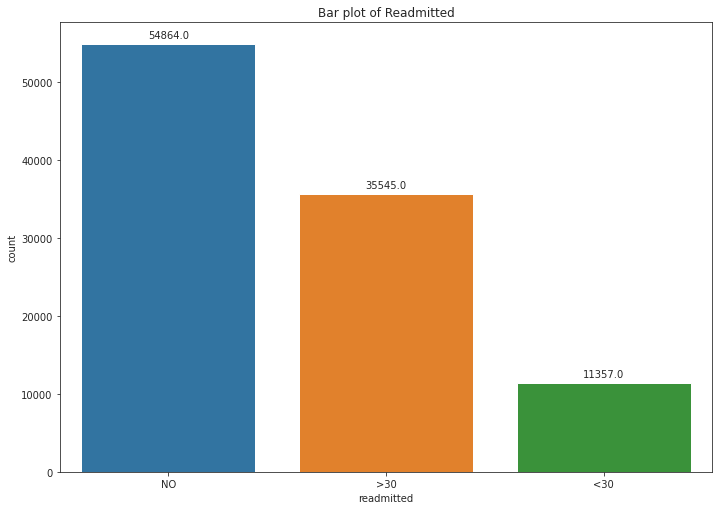

In [23]:
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size 
fig.set_size_inches(11.7, 8.27)
splot=sns.countplot(data=data, x="readmitted")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
splot.set(title='Bar plot of Readmitted')    

As we can see, there's an imbalance between the 3 classes. Let's keep exploring more to see what we can do about it.

[Text(0.5, 1.0, 'Distribution of race')]

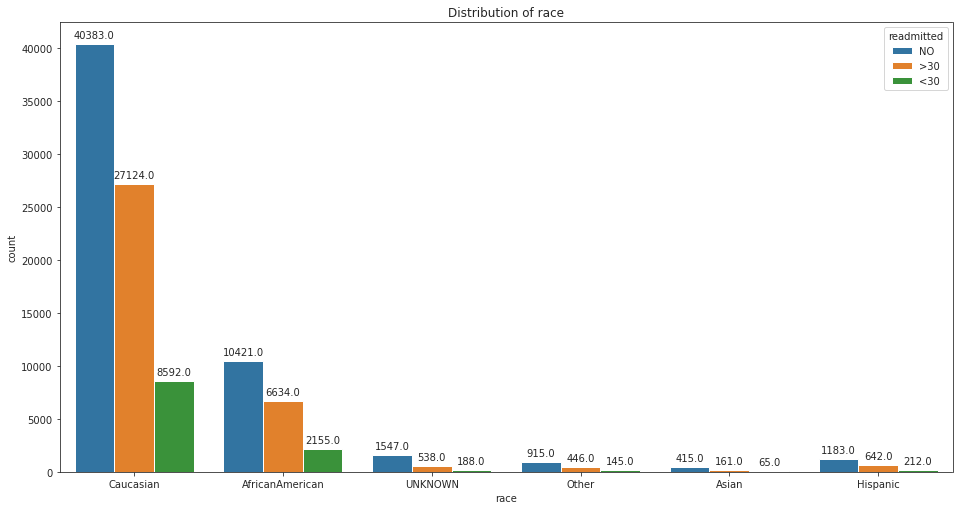

In [24]:
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size 
fig.set_size_inches(16, 8.27)
splot=sns.countplot(data=data, x="race",hue="readmitted")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
splot.set(title='Distribution of race')        

The majority of race is Caucasian, followed by AfricanAmerican.

[Text(0.5, 1.0, 'Distribution of gender')]

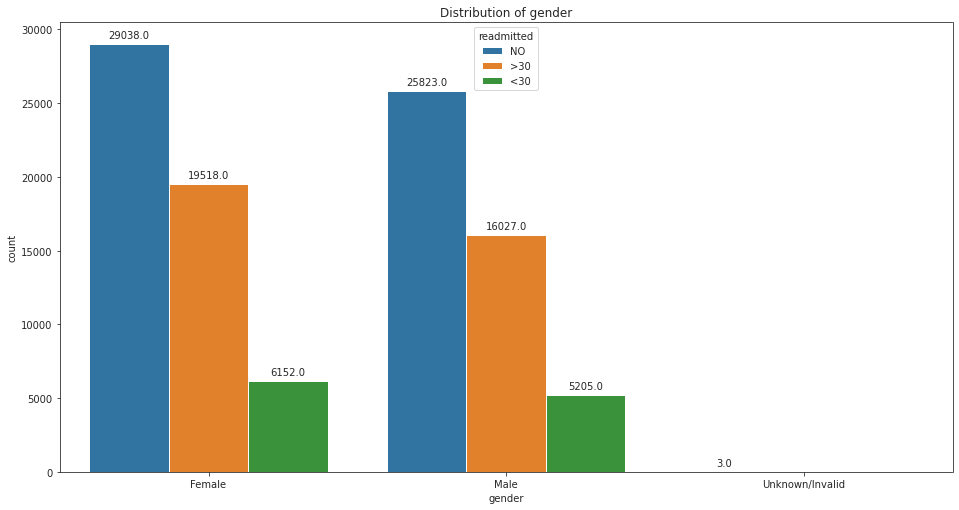

In [25]:
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size 
fig.set_size_inches(16, 8.27)
splot=sns.countplot(data=data, x="gender",hue="readmitted")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
splot.set(title='Distribution of gender')  

In [26]:
data.gender.value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

There are more females than males

[Text(0.5, 1.0, 'Distribution of age')]

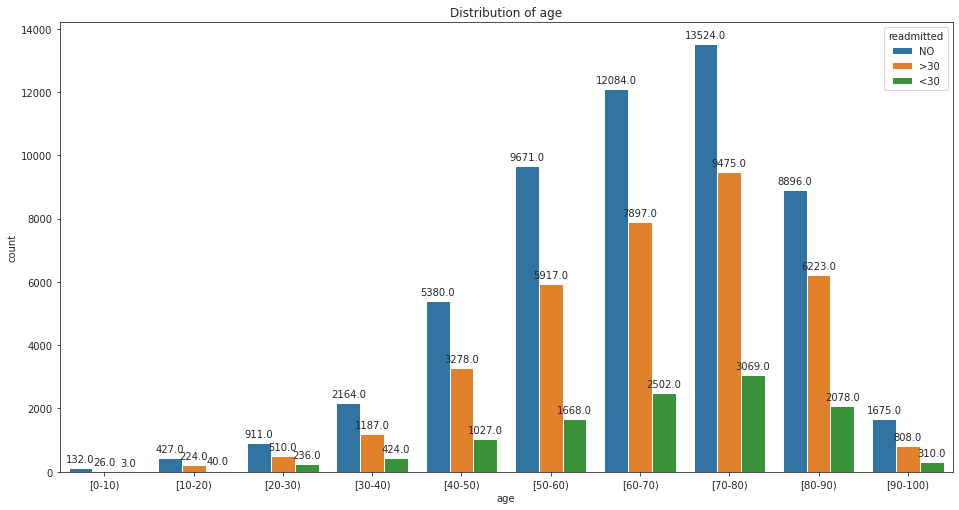

In [27]:
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size 
fig.set_size_inches(16, 8.27)
splot=sns.countplot(data=data, x="age",hue="readmitted")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
splot.set(title='Distribution of age')    

This graph shows us that the majority of people that are either re admitted or not is between the ages 50 to 80 or 90

[Text(0, 0, 'Emergency'),
 Text(0, 0, 'Urgent'),
 Text(0, 0, 'Elective'),
 Text(0, 0, 'Newborn'),
 Text(0, 0, 'Not Available'),
 Text(0, 0, 'NULL'),
 Text(0, 0, 'Trauma Center'),
 Text(0, 0, 'Not Mapped')]

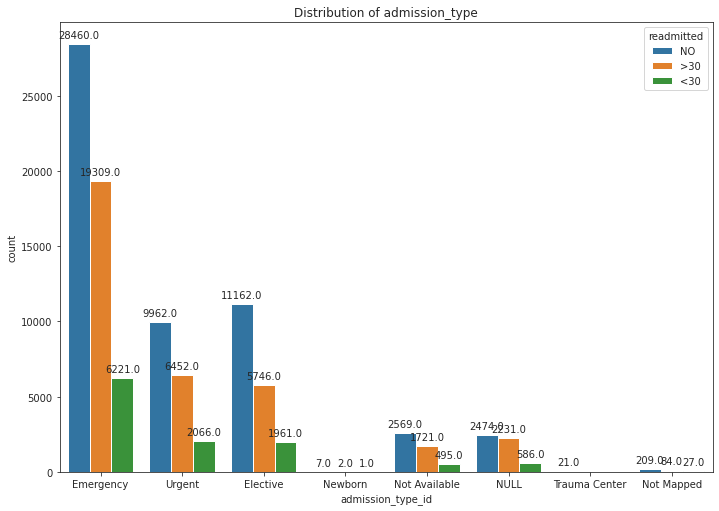

In [28]:
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size 
fig.set_size_inches(11.7, 8.27)
splot=sns.countplot(data=data, x="admission_type_id", hue="readmitted")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

splot.set(title='Distribution of admission_type') 
#Mapping taken from the file IDs_mapping.csv
splot.set_xticklabels(["Emergency",
"Urgent",
"Elective",
"Newborn",
"Not Available",
"NULL",
"Trauma Center",
"Not Mapped"])


As we can see, the type of admission of majority of people who are admitted is Emergency, followed by Urgent and Elective. 

[Text(0.5, 1.0, 'Number of days spent in the hospital')]

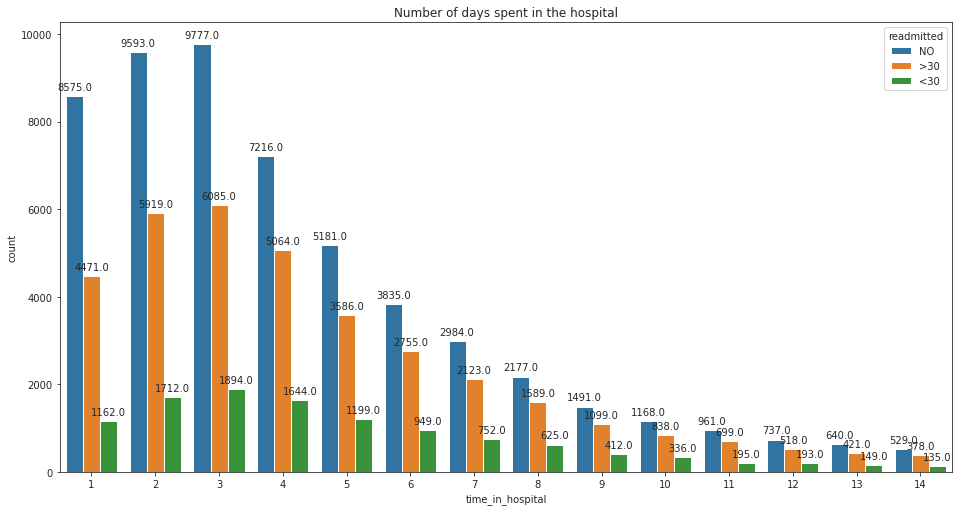

In [29]:
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size 
fig.set_size_inches(16, 8.27)
splot=sns.countplot(data=data, x="time_in_hospital",hue="readmitted")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
splot.set(title='Number of days spent in the hospital')   

The majority of people, either readmitted or not, spend 3 days at the hospoital, and very few (rare) spend more than 8 days 

[Text(0.5, 1.0, '# of patients that use Diabetes Medicine')]

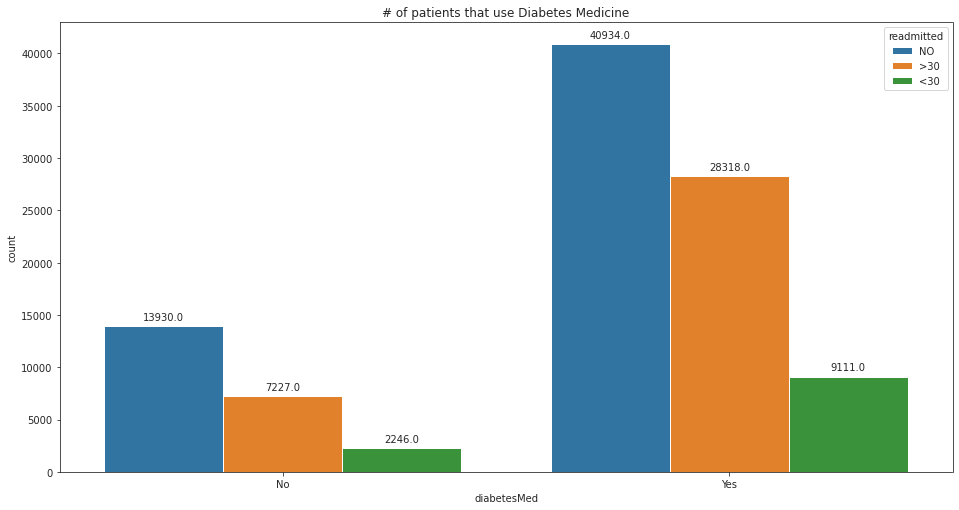

In [30]:
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size 
fig.set_size_inches(16, 8.27)
splot=sns.countplot(data=data, x="diabetesMed",hue="readmitted")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
splot.set(title='# of patients that use Diabetes Medicine')  

We can see that the majority of people use diabetes medicine.

[Text(0.5, 1.0, 'Medicine prescription')]

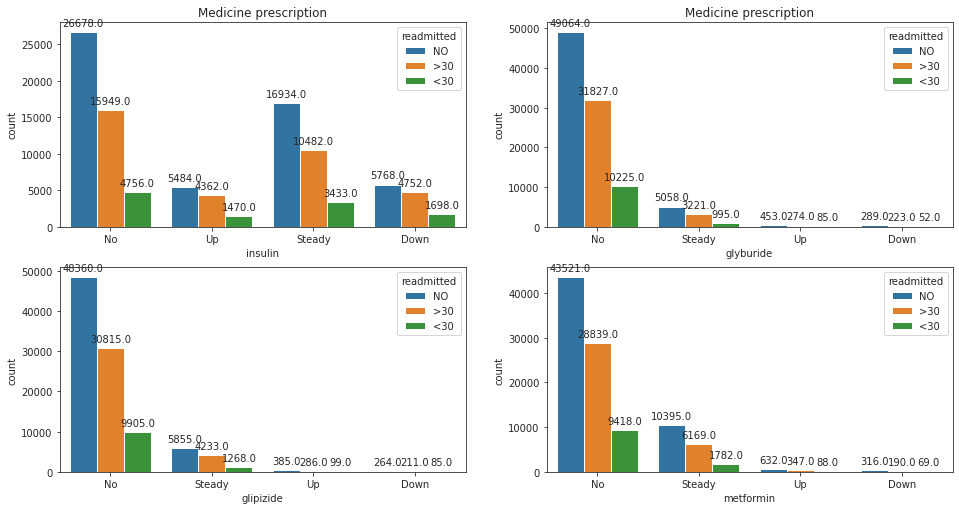

In [31]:
# plot
#	metformin	glipizide	glyburide	insulin
sns.set_style('ticks')
fig, ax = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(16, 8.27)
# the size 

splot=sns.countplot(data=data, x="insulin",hue="readmitted",ax=ax[0][0])
splot1=sns.countplot(data=data, x="glyburide",hue="readmitted",ax=ax[0][1])
splot2=sns.countplot(data=data, x="glipizide",hue="readmitted",ax=ax[1][0])
splot3=sns.countplot(data=data, x="metformin",hue="readmitted",ax=ax[1][1])
for p,q,r,s in zip(splot.patches,splot1.patches,splot2.patches,splot3.patches):
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
    splot1.annotate(format(q.get_height(), '.1f'), 
                   (q.get_x() + q.get_width() / 2., q.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
    splot2.annotate(format(r.get_height(), '.1f'), 
                   (r.get_x() + r.get_width() / 2., r.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
    splot3.annotate(format(s.get_height(), '.1f'), 
                   (s.get_x() + s.get_width() / 2., s.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')


splot.set(title='Medicine prescription')
splot1.set(title='Medicine prescription')

The previous graph shows us that the majority of people were prescribed insulin, and it shows a majority in a steady dose than an increment (up) or a decline (down) in a dose

Now let's do some basic bivariate analysis to see interesting patterns...

[Text(0.5, 1.0, '# of age vs # of days in hospital')]

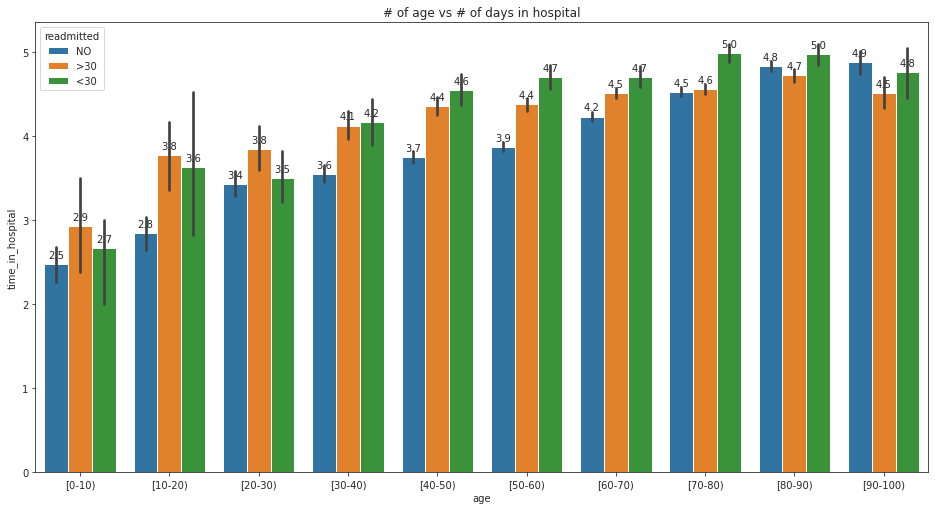

In [32]:
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size 
fig.set_size_inches(16, 8.27)
splot=sns.barplot(data=data, x="age",y="time_in_hospital", hue="readmitted")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
splot.set(title='# of age vs # of days in hospital') 

We can visualize that the elder people tend to stay more days in hospital, but also older people between  50 and 90 years of age, those that have been readmitted within 30 days, tend to stay more days  in the hospital in comparison with those who were not readmitted or the ones who were readmitted in the next 30 days.

[Text(0.5, 1.0, '# of age vs # of days in hospital')]

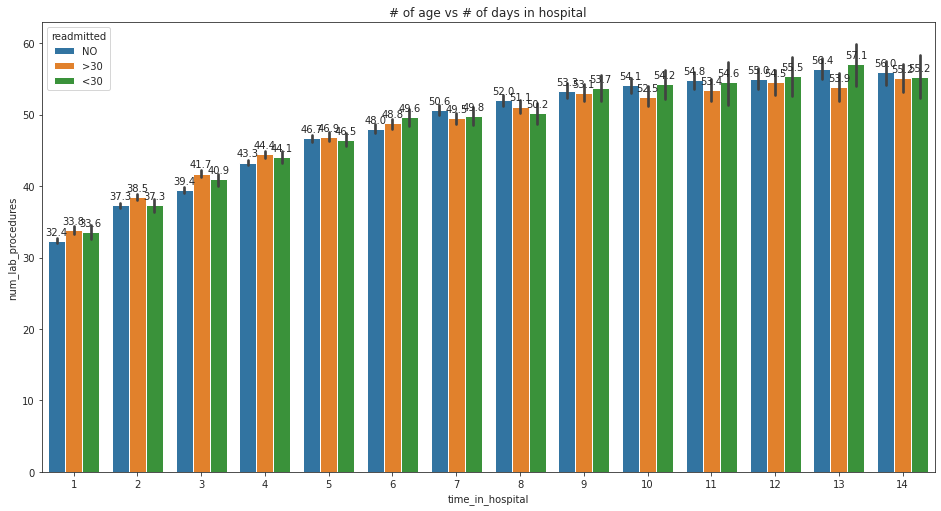

In [33]:
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size 
fig.set_size_inches(16, 8.27)
splot=sns.barplot(data=data, x="time_in_hospital",y="num_lab_procedures", hue="readmitted")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
splot.set(title='# of age vs # of days in hospital')

[Text(0.5, 1.0, '# of age vs # num_medications')]

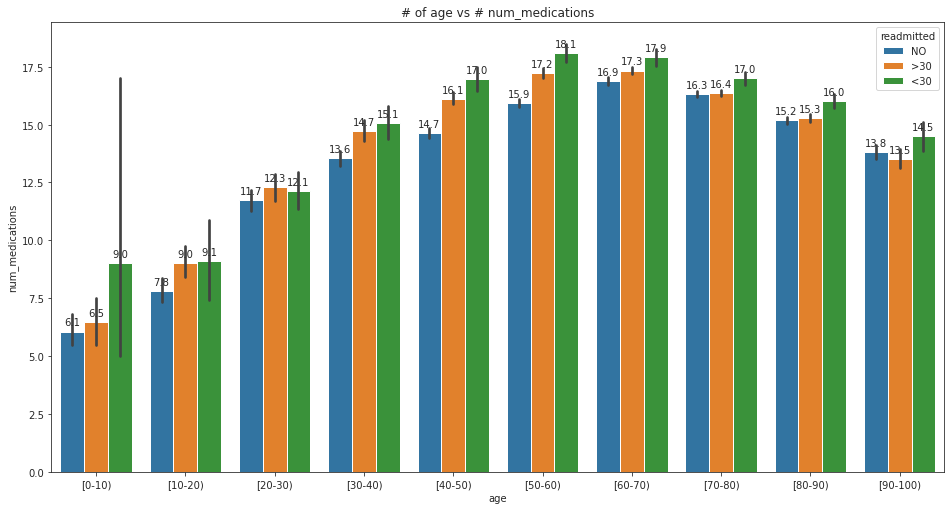

In [34]:
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size 
fig.set_size_inches(16, 8.27)
splot=sns.barplot(data=data, x="age",y="num_medications", hue="readmitted")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
splot.set(title='# of age vs # num_medications')

We see here 2 interesting patterns, as the age increases so the number of medications increases. We also see that the older people (from 50 to 100) who took around 17 or more different medications during the encounter, were the people who were readmitted within 30 days.

[Text(0.5, 1.0, '# of age vs insulin prescription')]

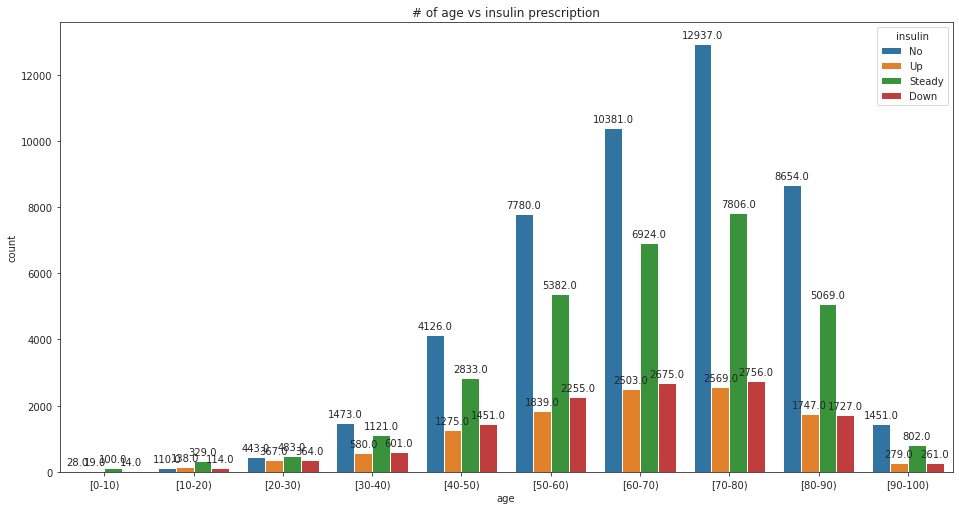

In [35]:
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size 
fig.set_size_inches(16, 8.27)
splot=sns.countplot(data=data, x="age", hue="insulin")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
splot.set(title='# of age vs insulin prescription')

In this plot we see that, the majortity of older people (from 50 to 90) were either no prescribed insulin or the actual dose was kept steady.

# Modeling (Preprocessing)

In the previous section we made a basic EDA, uni and bivariate analysis. It helped us gain some interesting insights and patterns from the data. We now proceed to make a model to help predict the target variable "readmitted". Before we model, we need to prepare our dataset, because we still have some categorical variables and the model works with numerical data.

Before we do that, let's first check if there exists multicolinearity between the columns. This is an important cehck, because if two or more columns convey the same information it'd be redundant to the model and may lead to overfit

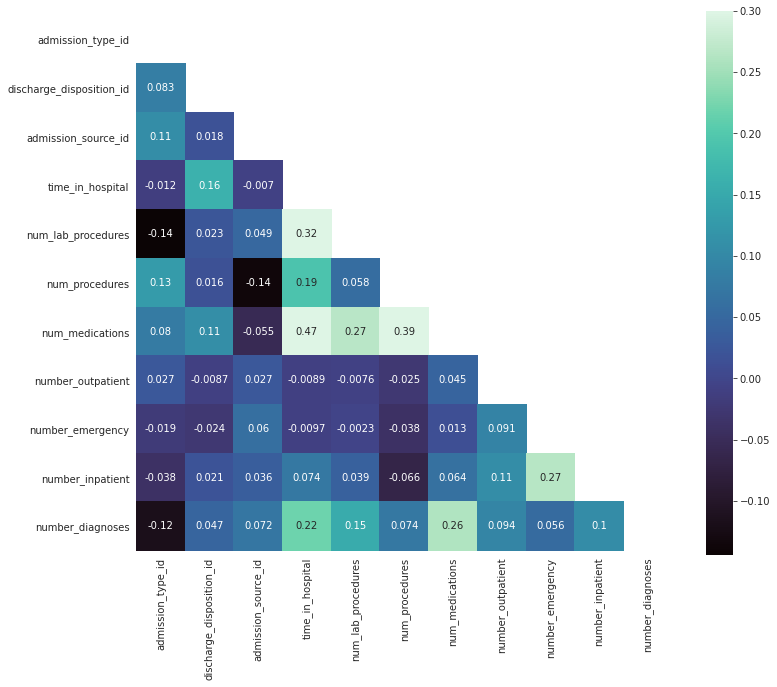

In [36]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 10))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True,cmap='mako',annot=True,)

We can see some variables like has_benn and number_impatient have high correlation. This is comepletely normal since number_inpatient is the number of visits of the patient in the year preceding the encounter. Another one is num_medications with time_in_hospital, it makes sense, becasue as we saw before, the more time one person spends in the hospital, more medications will be applied. Although they have almost 0.5 correlation, it's not bad.

Let's explore which columns are categorical variables...

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101766 non-null  object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   admission_type_id         101766 non-null  int64 
 4   discharge_disposition_id  101766 non-null  int64 
 5   admission_source_id       101766 non-null  int64 
 6   time_in_hospital          101766 non-null  int64 
 7   num_lab_procedures        101766 non-null  int64 
 8   num_procedures            101766 non-null  int64 
 9   num_medications           101766 non-null  int64 
 10  number_outpatient         101766 non-null  int64 
 11  number_emergency          101766 non-null  int64 
 12  number_inpatient          101766 non-null  int64 
 13  diag_1                    101766 non-null  object
 14  diag

To transform these categorical features (the ones of type object), would be very tedious to do it by hand because of its cardinality. Luckily, Sklearn gives us an amazing tool called LabelEncoder

Let's start the transformation...

In [38]:
#Look for the categorical. We drop out target variable, because we dont want to changr it
categorical_cols=dict(data.dtypes[data.dtypes=='O'])
del categorical_cols["readmitted"]

In [39]:
categorical_cols

{'A1Cresult': dtype('O'),
 'age': dtype('O'),
 'change': dtype('O'),
 'diabetesMed': dtype('O'),
 'diag_1': dtype('O'),
 'diag_2': dtype('O'),
 'diag_3': dtype('O'),
 'gender': dtype('O'),
 'glipizide': dtype('O'),
 'glyburide': dtype('O'),
 'insulin': dtype('O'),
 'metformin': dtype('O'),
 'race': dtype('O')}

In [40]:
for i in categorical_cols.keys():
  labelencoder = LabelEncoder()
  data[i]=labelencoder.fit_transform(data[i])
  print(i,"Transformed!")

race Transformed!
gender Transformed!
age Transformed!
diag_1 Transformed!
diag_2 Transformed!
diag_3 Transformed!
A1Cresult Transformed!
metformin Transformed!
glipizide Transformed!
glyburide Transformed!
insulin Transformed!
change Transformed!
diabetesMed Transformed!


Let's see the result...

In [41]:
data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,A1Cresult,metformin,glipizide,glyburide,insulin,change,diabetesMed,readmitted
0,2,0,0,6,25,1,1,41,0,1,0,0,0,124,709,747,1,2,1,1,1,1,1,0,NO
1,2,0,1,1,1,7,3,59,0,18,0,0,0,143,79,121,9,2,1,1,1,3,0,1,>30
2,0,0,2,1,1,7,2,11,5,13,2,0,1,454,78,767,6,2,1,2,1,1,1,1,NO
3,2,1,3,1,1,7,2,44,1,16,0,0,0,554,97,248,7,2,1,1,1,3,0,1,NO
4,2,1,4,1,1,7,1,51,0,8,0,0,0,54,24,86,5,2,1,2,1,2,0,1,NO


We made it! Now, back in the other sections we realized that there's an imbalance in the dataset between the three categories ("NO",">30","<30"). A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively classify the samples. In order to solve this, we will use a technique called SMOTE, was proposed by Nitesh Chawla, et al. in their 2002 paper named for the technique titled “SMOTE: Synthetic Minority Over-sampling Technique.”



## SMOTE
… SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b. — Page 47, Imbalanced Learning: Foundations, Algorithms, and Applications, 2013.

Let's take a look at the target variable

In [42]:
data.readmitted.value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [43]:
len(data)

101766

In [44]:
data.readmitted.value_counts()/len(data)*100

NO     53.911916
>30    34.928169
<30    11.159916
Name: readmitted, dtype: float64

Clearly imbalanced!! Let's make use of SMOTE to fix it! First we would oversample the minority class and then we will undersample the minority class as adviced on the SMOTE paper for better results. We will use the library imbalanced-learn

Before using SMOTE, we need to make some standarization in the data. This is important so we give the same importance to all the variables and we help other models that are sensitive to scales such as KNN. In this case, we will use StandardScaler from sklearn. We add a seed (random_state) for the reproducibility of the experiment

The proevious step in order to do the standarization is to split the data into two sets, train and test. We do this before standarization to avoid data leakage. Plus, SMOTE needs to be applied only in the training set

In [45]:
train,test = train_test_split(data, test_size=0.20, random_state=42)

In [46]:
col_names=list(data.columns[data.columns!="readmitted"])
scaler = StandardScaler()
scaled_data=scaler.fit_transform(train.loc[:,train.columns!="readmitted"])
train[col_names]=scaled_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [47]:
scaler = StandardScaler()
scaled_data=scaler.fit_transform(test.loc[:,test.columns!="readmitted"])
test[col_names]=scaled_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [48]:
train

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,A1Cresult,metformin,glipizide,glyburide,insulin,change,diabetesMed,readmitted
24079,0.269181,-0.928001,0.567053,-0.708108,-0.513659,0.306959,-0.134119,0.249395,-0.784879,-0.616845,-0.291171,-0.214154,-0.502261,-1.205851,-0.244276,-0.106595,0.815991,2.139529,-0.450110,-0.330098,-0.294623,-0.482609,0.927703,-1.825261,NO
98079,0.269181,1.077372,-0.686169,-0.708108,-0.513659,0.306959,-1.136220,-0.054612,-0.784879,-1.355826,-0.291171,-0.214154,-0.502261,-0.382729,-1.291735,-0.799277,-0.735143,0.203104,-0.450110,-0.330098,-0.294623,-0.482609,0.927703,-1.825261,>30
6237,0.269181,1.077372,1.193664,-0.708108,-0.513659,0.306959,-0.134119,0.046724,-0.784879,-0.740008,-0.291171,-0.214154,-0.502261,0.502750,1.546748,0.651537,-0.218099,0.203104,-0.450110,-0.330098,2.616280,-0.482609,0.927703,0.547867,NO
72208,0.269181,1.077372,1.193664,-0.708108,-0.135607,0.306959,-0.468152,0.553401,-0.784879,-0.986336,-0.291171,-0.214154,-0.502261,-0.919005,-0.722745,-0.564746,0.298946,0.203104,-0.450110,-0.330098,2.616280,0.708327,-1.077931,0.547867,NO
33075,-1.760417,-0.928001,0.567053,-0.708108,1.376599,0.306959,2.204116,-0.409285,0.974798,0.861118,-0.291171,-0.214154,0.287305,-0.625924,0.208329,-0.215678,0.298946,0.203104,-0.450110,-0.330098,-0.294623,-0.482609,0.927703,-1.825261,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0.269181,1.077372,0.567053,-0.708108,-0.513659,0.306959,-0.802186,-0.409285,-0.784879,-0.493681,-0.291171,-0.214154,-0.502261,1.269750,-0.114961,-0.172045,0.815991,0.203104,-0.450110,-0.330098,-0.294623,-0.482609,0.927703,-1.825261,>30
54886,0.269181,1.077372,-0.059558,2.067257,-0.513659,-1.170144,0.199915,1.009410,0.388239,0.861118,-0.291171,-0.214154,-0.502261,0.864425,1.617872,-1.551954,0.815991,0.203104,1.842024,-0.330098,-0.294623,1.899264,-1.077931,0.547867,<30
76820,0.269181,1.077372,0.567053,0.679574,-0.135607,-1.170144,-0.468152,0.604068,-0.198320,2.092753,-0.291171,-0.214154,-0.502261,1.026555,-0.250742,-0.832002,0.815991,0.203104,-0.450110,-0.330098,-0.294623,-1.673546,-1.077931,0.547867,NO
860,0.269181,-0.928001,-0.059558,2.761098,4.022961,0.306959,2.538150,1.718757,0.388239,0.614790,-0.291171,-0.214154,-0.502261,0.060011,0.182466,0.651537,0.815991,0.203104,-0.450110,-0.330098,2.616280,-1.673546,-1.077931,0.547867,>30


In [49]:
test

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,A1Cresult,metformin,glipizide,glyburide,insulin,change,diabetesMed,readmitted
35956,0.279728,-0.924983,0.565088,-0.709948,-0.516972,0.059020,2.245938,1.278517,-0.787476,0.480889,-0.292630,-0.206558,-0.507442,-1.346476,0.759902,-0.871573,-1.255782,0.21676,-0.445511,-0.343609,-0.297835,0.710668,0.922152,0.540967,NO
60927,0.279728,1.080674,-0.695314,-0.709948,-0.516972,-1.168796,-1.143585,-1.192729,-0.787476,-1.112213,-0.292630,-0.206558,-0.507442,1.206557,-0.121461,2.443346,0.297274,0.21676,1.868918,-0.343609,-0.297835,-0.486562,0.922152,0.540967,NO
79920,0.279728,-0.924983,-0.065113,0.658255,0.437342,-1.168796,-0.126728,-1.141244,0.967381,0.848528,0.489124,-0.206558,1.094991,1.002561,1.338900,1.148113,-0.220412,0.21676,1.868918,-0.343609,-0.297835,-0.486562,0.922152,0.540967,NO
50078,0.279728,1.080674,-1.955716,-0.025846,-0.516972,-1.168796,2.584891,-0.780854,-0.787476,0.358343,-0.292630,-0.206558,0.293774,-0.042142,-0.932057,-1.546631,-0.220412,0.21676,-0.445511,-0.343609,-0.297835,-0.486562,0.922152,0.540967,>30
44080,-1.754419,-0.924983,-0.065113,-0.709948,-0.326110,0.304583,-1.143585,-1.141244,-0.787476,-1.234759,-0.292630,-0.206558,-0.507442,-0.518131,0.682703,-0.103214,-0.220412,0.21676,-0.445511,2.383027,-0.297835,-0.486562,0.922152,0.540967,<30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16156,0.279728,1.080674,1.195289,-0.709948,-0.516972,0.304583,0.551176,0.403284,-0.202523,0.113250,-0.292630,-0.206558,-0.507442,-0.085414,-0.115027,-0.108703,0.297274,0.21676,-0.445511,-0.343609,-0.297835,0.710668,0.922152,0.540967,<30
67386,0.279728,1.080674,-1.325515,0.658255,-0.516972,-1.168796,-0.804633,0.300316,-0.202523,-0.009296,-0.292630,-0.206558,1.094991,-1.760648,-1.633287,-1.102081,0.814959,0.21676,1.868918,-0.343609,2.597170,0.710668,-1.084420,0.540967,<30
81342,0.279728,-0.924983,0.565088,-0.709948,-0.516972,0.304583,1.568034,-0.111559,0.382429,0.113250,2.052632,-0.206558,-0.507442,0.365849,-0.938490,-0.108703,0.814959,0.21676,1.868918,-0.343609,-0.297835,-0.486562,0.922152,0.540967,>30
72915,0.279728,1.080674,0.565088,-0.025846,-0.516972,0.304583,-0.804633,-1.089760,-0.787476,-1.357306,-0.292630,-0.206558,-0.507442,0.359667,0.624803,-0.169074,-0.220412,0.21676,-0.445511,-0.343609,-0.297835,0.710668,0.922152,0.540967,>30


Now that we have split and standarized our data, we are ready for SMOTE

Let's see again the distribution of the data...

In [50]:
train.shape

(81412, 25)

In [51]:
train["readmitted"].value_counts()

NO     43912
>30    28428
<30     9072
Name: readmitted, dtype: int64

In [52]:
train["readmitted"].value_counts()/len(train)

NO     0.539380
>30    0.349187
<30    0.111433
Name: readmitted, dtype: float64

Let's create a pipeline for simplicity. This pipeline will oversmaple (using smote) and then undersample the majority class.

In [53]:
over = SMOTE()
under = RandomUnderSampler(sampling_strategy={"NO":20000,">30":20000,"<30":20000})
# define pipeline,
steps = [('o', over),('u',under)]
pipeline = Pipeline(steps=steps)

In [54]:
# transform the dataset
Xsmote, ysmote = pipeline.fit_resample(train.loc[:,train.columns!="readmitted"], train["readmitted"])

In [55]:
ysmote.value_counts()

<30    20000
NO     20000
>30    20000
Name: readmitted, dtype: int64

In [56]:
ysmote.value_counts()/len(ysmote)

<30    0.333333
NO     0.333333
>30    0.333333
Name: readmitted, dtype: float64

In [57]:
len(Xsmote)

60000

In [58]:
len(ysmote)

60000

Now we see, the dataset is much more balanced now. We applied a combination of undersampling and SMOTE because the authors of the original paper (“SMOTE: Synthetic Minority Over-sampling Technique.”) suggested that it had better results.

We tranform it back to a dataset and then we proceed to next phase

In [59]:
Xsmote=pd.DataFrame(Xsmote,columns=data.columns[data.columns!="readmitted"])

In [60]:
Xsmote

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,A1Cresult,metformin,glipizide,glyburide,insulin,change,diabetesMed
0,0.885332,-0.928001,0.567053,2.761098,-0.513659,0.306959,-0.277307,0.562413,-0.784879,-0.181399,-0.291171,-0.214154,5.024701,0.525064,0.819750,0.118370,-1.049075,0.203104,-0.450110,2.420277,-0.294623,-0.482609,0.927703,0.547867
1,3.313579,1.077372,-0.059558,-0.014267,-0.135607,-1.170144,1.202015,-0.003944,-0.198320,-0.370518,-0.291171,-0.214154,1.076871,-1.343038,1.346309,1.169685,-1.252188,0.203104,-0.450110,-0.330098,-0.294623,0.708327,-1.077931,0.547867
2,0.709368,-0.928001,-0.414366,2.067257,0.431470,2.768797,-0.367508,-1.224837,-0.784879,-0.649475,1.186006,0.252990,0.287305,-0.713564,-0.727431,0.651537,0.815991,0.203104,-0.450110,-0.330098,-0.294623,-0.482609,0.927703,-1.825261
3,0.269181,1.077372,0.567053,0.679574,3.455883,-1.170144,-0.802186,-2.131987,-0.784879,-0.986336,-0.291171,-0.214154,0.287305,-0.339079,1.520885,1.164231,0.298946,0.203104,-0.450110,-0.330098,-0.294623,-0.482609,0.927703,-1.825261
4,0.269181,1.077372,0.567053,-0.708108,-0.049979,0.306959,2.235517,0.688227,0.886228,1.655892,-0.291171,-0.214154,-0.383037,-0.042960,-1.227058,0.111141,0.815991,0.495503,-0.450110,-0.330098,2.616280,-0.302779,-1.077931,0.547867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.269181,-0.928001,-0.059558,0.679574,-0.513659,-1.170144,-0.468152,-2.030651,1.561358,0.737954,-0.291171,-0.214154,0.287305,-1.841899,-0.250742,-0.832002,-0.735143,0.203104,1.842024,2.420277,-0.294623,0.708327,-1.077931,0.547867
59996,0.269181,1.077372,1.193664,-0.708108,-0.513659,0.306959,-0.802186,0.452065,-0.784879,-0.493681,-0.291171,-0.214154,0.287305,1.269750,-0.186084,2.636861,-0.218099,0.203104,-0.450110,-0.330098,-0.294623,0.708327,0.927703,0.547867
59997,-1.760417,-0.928001,0.567053,-0.708108,-0.513659,0.306959,0.533948,0.452065,0.974798,0.737954,-0.291171,-0.214154,-0.502261,-0.482501,-0.108495,-0.172045,0.298946,-1.733320,-0.450110,-0.330098,-0.294623,-0.482609,0.927703,-1.825261
59998,0.269181,-0.928001,-1.939390,-0.708108,-0.513659,0.306959,-0.802186,0.756071,0.388239,0.861118,-0.291171,-0.214154,-0.502261,0.359328,-1.291735,-0.799277,-0.735143,0.203104,-0.450110,-0.330098,-0.294623,-0.482609,0.927703,-1.825261


In [61]:
ysmote

0        <30
1        <30
2        <30
3        <30
4        <30
        ... 
59995     NO
59996     NO
59997     NO
59998     NO
59999     NO
Name: readmitted, Length: 60000, dtype: object

# Modeling (Experiment and prediction)

It's time to do some experiments... We first start off with the dataset without SMOTE. Then we do another experiment with SMOTE and compare how well the models learn. We will use the following algorithms: Random Forest, Logisitic Regression, KNN, SVM.  We will also include the Kfold cross validation, because is really important when it comes to unbalanced datasets. Let's see which model is better...

### Random Forest

Without SMOTE

In [62]:
rdf = RandomForestClassifier().fit(train.loc[:,train.columns!="readmitted"], train["readmitted"])
pred1=rdf.predict(test.loc[:,test.columns!="readmitted"])
cm=confusion_matrix(test["readmitted"], pred1)

accuracy = accuracy_score( test["readmitted"],pred1)
print(rdf)
print(accuracy)
print(classification_report(test["readmitted"],pred1, labels=None))
print("COHEN")
print(cohen_kappa_score(test["readmitted"], pred1))
print(" Confusion Matrix")
print(cm)

RandomForestClassifier()
0.5801316694507223
              precision    recall  f1-score   support

         <30       0.43      0.01      0.03      2285
         >30       0.49      0.38      0.43      7117
          NO       0.61      0.83      0.70     10952

    accuracy                           0.58     20354
   macro avg       0.51      0.41      0.39     20354
weighted avg       0.55      0.58      0.53     20354

COHEN
0.18470009892792405
 Confusion Matrix
[[  30  943 1312]
 [  31 2733 4353]
 [   9 1898 9045]]


We can't cased our judgement in the Accuracy metric since we have an inbalanced dataset. Let's try CV so we can know better

In [64]:
scores_Acc = cross_val_score(RandomForestClassifier(), train.loc[:,train.columns!="readmitted"], train["readmitted"], cv=5)
scores_Acc.mean()

0.5800987150692166

In [65]:
scores_k = cross_val_score(RandomForestClassifier(), train.loc[:,train.columns!="readmitted"], train["readmitted"], cv=5,scoring="f1_macro")
scores_k.mean()

0.3909975443391302

As we can see, we could use F1 Macro to see how well it performs taking into account the recall and precision. We see that it's pretty low

Before we continue, is important to show that the Trees have an important function called Feature_Importances. With it, we are able to see which variables played an important role.

Feature ranking:
1. feature 7 (0.101395)
2. feature 13 (0.095145)
3. feature 14 (0.094984)
4. feature 15 (0.093465)
5. feature 9 (0.087531)
6. feature 6 (0.063548)
7. feature 2 (0.051589)
8. feature 4 (0.042831)
9. feature 12 (0.042808)
10. feature 16 (0.041350)
11. feature 8 (0.040453)
12. feature 21 (0.030778)
13. feature 3 (0.028052)
14. feature 0 (0.024656)
15. feature 5 (0.021683)
16. feature 1 (0.020913)
17. feature 17 (0.019985)
18. feature 10 (0.017739)
19. feature 18 (0.015961)
20. feature 22 (0.014659)
21. feature 19 (0.014233)
22. feature 11 (0.014065)
23. feature 20 (0.012775)
24. feature 23 (0.009403)


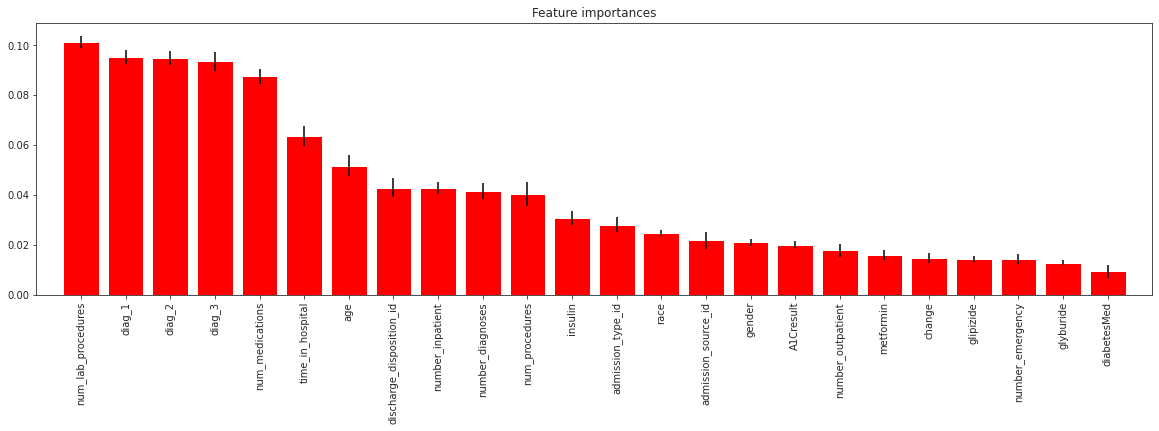

In [66]:
importances = rdf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rdf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
X_train=train.loc[:,train.columns!="readmitted"]
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(20,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.iloc[:,np.argsort(importances)[::-1]].columns, rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()


It's interesting to see that the number of lab procedures is the most important variable followed by the diagnostics. And the worst is diabetes_med followed by glyburide.

Now, with SMOTE

In [68]:
rdf = RandomForestClassifier().fit(Xsmote, ysmote )
pred1=rdf.predict(test.loc[:,test.columns!="readmitted"])
cm=confusion_matrix(test["readmitted"], pred1)

accuracy = accuracy_score( test["readmitted"],pred1)
print(rdf)
print(accuracy)
print(classification_report(test["readmitted"],pred1, labels=None))
print("COHEN")
print(cohen_kappa_score(test["readmitted"], pred1))
print(" Confusion Matrix")
print(cm)

RandomForestClassifier()
0.28775670629851624
              precision    recall  f1-score   support

         <30       0.14      0.62      0.23      2285
         >30       0.37      0.42      0.39      7117
          NO       0.74      0.13      0.23     10952

    accuracy                           0.29     20354
   macro avg       0.41      0.39      0.28     20354
weighted avg       0.54      0.29      0.28     20354

COHEN
0.05241272258091112
 Confusion Matrix
[[1417  769   99]
 [3725 2969  423]
 [5125 4356 1471]]


At first it might seem worse, but let's try with cv to see what happens...

In [69]:
scores = cross_val_score(RandomForestClassifier(), Xsmote, ysmote, cv=5)
scores.mean()

0.6569

Since with SMOTE this dataset is now balanced, we can now take a look at the accuracy. Is not much, but sure is better than a coin toss.

In [70]:
scores_k = cross_val_score(RandomForestClassifier(), Xsmote, ysmote, cv=5,scoring="f1_macro")
scores_k.mean()

0.6486312180707203

Using F1 Macro, we see a huge improvement in contrast with the experiment without SMOTE

##SVM

It run for so long and didnt finish... SVM is great but inefficient with large datasets

Without SMOTE

In [ ]:
from sklearn import svm
SVM = svm.SVC(gamma='scale').fit(train.loc[:,train.columns!="readmitted"], train["readmitted"])
pred=SVM.predict(test.loc[:,test.columns!="readmitted"])
cm=confusion_matrix(test["readmitted"], pred)

accuracy = accuracy_score( test["readmitted"],pred)
print(SVM)
print(accuracy)
print(classification_report(test["readmitted"],pred, labels=None))
print("COHEN")
print(cohen_kappa_score(test["readmitted"], pred))
print(" Confusion Matrix")
print(cm)

In [ ]:
scores = cross_val_score(svm.SVC(gamma='scale'), Xsmote, ysmote, cv=5)
scores.mean()

In [ ]:
scores_k = cross_val_score(svm.SVC(gamma='scale'), Xsmote, ysmote, cv=5,scoring="f1_macro")
scores_k.mean()

With SMOTE

In [ ]:
from sklearn import svm
SVM = svm.SVC(gamma='scale').fit(Xsmote, ysmote )
pred=SVM.predict(test.loc[:,test.columns!="readmitted"])
cm=confusion_matrix(test["readmitted"], pred)

accuracy = accuracy_score( test["readmitted"],pred)
print(SVM)
print(accuracy)
print(classification_report(test["readmitted"],pred, labels=None))
print("COHEN")
print(cohen_kappa_score(test["readmitted"], pred))
print(" Confusion Matrix")
print(cm)

In [ ]:
scores_Acc = cross_val_score(svm.SVC(gamma='scale'), train.loc[:,train.columns!="readmitted"], train["readmitted"], cv=5)
scores.mean()

In [ ]:
scores_k = cross_val_score(svm.SVC(gamma='scale'), train.loc[:,train.columns!="readmitted"], train["readmitted"], cv=5,scoring="f1_macro")
scores_k.mean()

0.3923274050358078

#Naive Bayes

Without SMOTE

In [71]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(train.loc[:,train.columns!="readmitted"], train["readmitted"])
pred=gnb.predict(test.loc[:,test.columns!="readmitted"])
cm=confusion_matrix(test["readmitted"], pred)

accuracy = accuracy_score( test["readmitted"],pred)
print(gnb)
print(accuracy)
print(classification_report(test["readmitted"],pred, labels=None))
print("COHEN")
print(cohen_kappa_score(test["readmitted"], pred))
print(" Confusion Matrix")
print(cm)

GaussianNB()
0.5575808194949395
              precision    recall  f1-score   support

         <30       0.28      0.10      0.14      2285
         >30       0.49      0.18      0.27      7117
          NO       0.58      0.90      0.71     10952

    accuracy                           0.56     20354
   macro avg       0.45      0.39      0.37     20354
weighted avg       0.52      0.56      0.49     20354

COHEN
0.1207813420440983
 Confusion Matrix
[[ 222  421 1642]
 [ 384 1298 5435]
 [ 196  927 9829]]


In [72]:
scores = cross_val_score(GaussianNB(), train.loc[:,train.columns!="readmitted"], train["readmitted"], cv=5)
scores.mean()

0.5583452199719849

In [73]:
scores_k = cross_val_score(GaussianNB(), train.loc[:,train.columns!="readmitted"], train["readmitted"], cv=5,scoring="f1_macro")
scores_k.mean()

0.3745598794698292

Very similar to Random Forest...

With SMOTE

In [74]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(Xsmote, ysmote )
pred=gnb.predict(test.loc[:,test.columns!="readmitted"])
cm=confusion_matrix(test["readmitted"], pred)

accuracy = accuracy_score( test["readmitted"],pred)
print(gnb)
print(accuracy)
print(classification_report(test["readmitted"],pred, labels=None))
print("COHEN")
print(cohen_kappa_score(test["readmitted"], pred))
print(" Confusion Matrix")
print(cm)

GaussianNB()
0.5236317185811142
              precision    recall  f1-score   support

         <30       0.21      0.28      0.24      2285
         >30       0.47      0.15      0.23      7117
          NO       0.60      0.81      0.69     10952

    accuracy                           0.52     20354
   macro avg       0.43      0.42      0.39     20354
weighted avg       0.51      0.52      0.48     20354

COHEN
0.13214592952400328
 Confusion Matrix
[[ 650  292 1343]
 [1385 1092 4640]
 [1093  943 8916]]


In [75]:
scores_Acc = cross_val_score(GaussianNB(), Xsmote, ysmote, cv=5)
scores.mean()

0.5583452199719849

A little worse than Random Forest

In [77]:
scores_k = cross_val_score(GaussianNB(), Xsmote, ysmote, cv=5,scoring="f1_macro")
scores_k.mean()

0.3729515445515124

Random Forest is still better

#KNN

Without SMOTE

In [78]:
neigh = KNeighborsClassifier(n_neighbors=3).fit(train.loc[:,train.columns!="readmitted"], train["readmitted"])
pred=neigh.predict(test.loc[:,test.columns!="readmitted"])
cm=confusion_matrix(test["readmitted"], pred)

accuracy = accuracy_score( test["readmitted"],pred)
print(gnb)
print(accuracy)
print(classification_report(test["readmitted"],pred, labels=None))
print("COHEN")
print(cohen_kappa_score(test["readmitted"], pred))
print(" Confusion Matrix")
print(cm)

GaussianNB()
0.4723887196619829
              precision    recall  f1-score   support

         <30       0.14      0.19      0.16      2285
         >30       0.40      0.34      0.37      7117
          NO       0.59      0.62      0.61     10952

    accuracy                           0.47     20354
   macro avg       0.38      0.38      0.38     20354
weighted avg       0.48      0.47      0.47     20354

COHEN
0.08840673159430679
 Confusion Matrix
[[ 424  817 1044]
 [1136 2390 3591]
 [1381 2770 6801]]


In [79]:
scores_Acc = cross_val_score(KNeighborsClassifier(n_neighbors=3), train.loc[:,train.columns!="readmitted"], train["readmitted"], cv=5)
scores.mean()

0.5583452199719849

In [80]:
scores_k = cross_val_score(KNeighborsClassifier(n_neighbors=3), train.loc[:,train.columns!="readmitted"], train["readmitted"], cv=5,scoring="f1_macro")
scores_k.mean()

0.3764961082755309

Similar to Random Forest

With SMOTE

In [81]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3).fit(Xsmote, ysmote )
pred=neigh.predict(test.loc[:,test.columns!="readmitted"])
cm=confusion_matrix(test["readmitted"], pred)

accuracy = accuracy_score( test["readmitted"],pred)
print(gnb)
print(accuracy)
print(classification_report(test["readmitted"],pred, labels=None))
print("COHEN")
print(cohen_kappa_score(test["readmitted"], pred))
print(" Confusion Matrix")
print(cm)

GaussianNB()
0.3652844649700305
              precision    recall  f1-score   support

         <30       0.13      0.42      0.20      2285
         >30       0.38      0.36      0.37      7117
          NO       0.63      0.36      0.46     10952

    accuracy                           0.37     20354
   macro avg       0.38      0.38      0.34     20354
weighted avg       0.49      0.37      0.40     20354

COHEN
0.06657500770451918
 Confusion Matrix
[[ 966  789  530]
 [2781 2554 1782]
 [3737 3300 3915]]


In [82]:
scores_Acc = cross_val_score(KNeighborsClassifier(n_neighbors=3), Xsmote, ysmote, cv=5)
scores.mean()

0.5583452199719849

In [83]:
scores_k = cross_val_score(KNeighborsClassifier(n_neighbors=3), Xsmote, ysmote, cv=5,scoring="f1_macro")
scores_k.mean()

0.5565955193294382

Random Forest still wins! Better than KNN

#Logistic Regression

Without SMOTE

In [84]:
logisticRegr = LogisticRegression()

logisticRegr.fit(train.loc[:,train.columns!="readmitted"], train.loc[:,"readmitted"])
print("LR")
pred = logisticRegr.predict(test.loc[:,test.columns!="readmitted"])


cm=confusion_matrix(test["readmitted"], pred)

accuracy = accuracy_score( test["readmitted"],pred)
print(gnb)
print(accuracy)
print(classification_report(test["readmitted"],pred, labels=None))
print("COHEN")
print(cohen_kappa_score(test["readmitted"], pred))
print(" Confusion Matrix")
print(cm)

LR
GaussianNB()
0.5703055910386164
              precision    recall  f1-score   support

         <30       0.37      0.01      0.02      2285
         >30       0.50      0.24      0.33      7117
          NO       0.59      0.90      0.71     10952

    accuracy                           0.57     20354
   macro avg       0.48      0.38      0.35     20354
weighted avg       0.53      0.57      0.50     20354

COHEN
0.1322465423794945
 Confusion Matrix
[[  22  636 1627]
 [  23 1735 5359]
 [  15 1086 9851]]


In [85]:
scores_Acc = cross_val_score(LogisticRegression(), train.loc[:,train.columns!="readmitted"], train.loc[:,"readmitted"], cv=5)
scores.mean()

0.5583452199719849

In [86]:
scores_k = cross_val_score(LogisticRegression(), train.loc[:,train.columns!="readmitted"], train.loc[:,"readmitted"], cv=5,scoring="f1_macro")
scores_k.mean()

0.3513714197402965

With SMOTE

In [87]:
logisticRegr = LogisticRegression()

logisticRegr.fit(Xsmote, ysmote)
print("LR")
pred = logisticRegr.predict(test.loc[:,test.columns!="readmitted"])


cm=confusion_matrix(test["readmitted"], pred)

accuracy = accuracy_score( test["readmitted"],pred)
print(gnb)
print(accuracy)
print(classification_report(test["readmitted"],pred, labels=None))
print("COHEN")
print(cohen_kappa_score(test["readmitted"], pred))
print(" Confusion Matrix")
print(cm)

LR
GaussianNB()
0.47474697848088826
              precision    recall  f1-score   support

         <30       0.18      0.38      0.25      2285
         >30       0.42      0.29      0.34      7117
          NO       0.64      0.61      0.62     10952

    accuracy                           0.47     20354
   macro avg       0.41      0.43      0.40     20354
weighted avg       0.51      0.47      0.48     20354

COHEN
0.13769906905453078
 Confusion Matrix
[[ 877  587  821]
 [2021 2062 3034]
 [1965 2263 6724]]


In [88]:
scores_Acc = cross_val_score(LogisticRegression(), Xsmote, ysmote, cv=5)
scores.mean()

0.5583452199719849

In [89]:
scores_k = cross_val_score(LogisticRegression(), Xsmote, ysmote, cv=5,scoring="f1_macro")
scores_k.mean()

0.42569598330649105

Random Forest is the winner!! Knn better than Logistic Regression.

#Conclussion

We made an interesting journy cleaning, exploring and modeling this dataset. We could gain some interesting insights from the visualization, that in the future one could use for the benefit of the patients. Although the main goal was to make a classification model to predict if the patient will be readmitted  within 30 or more days, or definitely won't be.

Our best model is Random Forest. With an accuracy of 0.65 percent and a F1 score of 0.64. There's still room for improvement, perhaps using hyperparameter optimization or other models such as Convolutional Neural Networks. Like a famous statistician said "All models are wrong, but some are useful”. George E. P. Box.

Our model will help us guide the way, better than a coin toss. 

Thank you so much for taking the time to read the notebook!

Jhoan Steven D.V

#References



* https://imbalanced-learn.org/stable/
* https://scikit-learn.org/stable/index.html
* https://matplotlib.org/stable/index.html
* https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
* https://machinelearningmastery.com/multi-class-imbalanced-classification/
* https://seaborn.pydata.org/index.html

